## Predict Final Result Block
跑完這個 block 以後，就可以得到 final CSV

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tqdm import tqdm
import csv

df = pd.read_csv("./hw3_meta/prediction_example.csv")
patientList = df['PATIENT ID'].tolist()

# CXR Data Preprocessing
data = []
for id in tqdm(patientList):
  filepath = './predicting_images/' + str(id) + '.jpg'
  img = keras.preprocessing.image.load_img(filepath, grayscale=True, target_size=(64, 64))
  img = np.array(img)
  data.append(img)
data = np.array(data).reshape(-1, 64, 64, 1)

CXR_Dataset = data / 255.0

# EHR Data Preprocessing
data = pd.read_csv('./hw3_meta/fixed_test.csv')

# Create Dataframe
df = pd.DataFrame(data)
df = df[df['PATIENT ID'].isin(patientList)]
df = df.drop(columns=['admission_datetime', 'PATIENT ID', 'sex'])

# Since ed_diagnosis is STRING LABEL, we need to transform the string to integer label for further training
df = pd.get_dummies(df)

# Fill NAN values
headerList = df.columns.values.tolist()
filteredList = list(filter(lambda name: 'pmhx' in name, headerList)) # need to fill mode
otherList = list(filter(lambda name: 'pmhx' not in name, headerList)) # need to fill mean

for filteredCol in filteredList:
  df[filteredCol].fillna(df[filteredCol].mode()[0], inplace=True)

for otherCol in otherList:
  df[otherCol].fillna(df[otherCol].mean(), inplace=True)

EHR_Dataset = df.to_numpy()

loadedModel = keras.models.load_model("./hw3_meta/bonus_model-16-0.999-0.31-0.55-f1-0.39.h5")
predict_ans = loadedModel.predict([CXR_Dataset, EHR_Dataset])
predict_ans = predict_ans.round() # Force output to [0, 1]

with open('Bonus_106062322.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['PATIENT ID', 'hospital_outcome'])
  for idx, val in enumerate(predict_ans):
    writer.writerow([ patientList[idx], int(predict_ans[idx][0])])


  0%|          | 0/457 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 457/457 [00:00<00:00, 825.86it/s]


## HW3: [BONUS] CNN implementation
**It's unnecessary to run if only need to generate predict result!**


## Data Preprocessing

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Mounted at /content/drive


In [13]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tqdm import tqdm

from tensorflow.keras import layers, models, preprocessing
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/My Drive/ML-Homework/hw3/cxr_label_train.csv")
patient_ids = df['PATIENT ID'].tolist()
label = np.array(df['hospital_outcome']).reshape(-1, 1)

data = []
for id in tqdm(patient_ids):
  filepath = '/content/drive/My Drive/ML-Homework/hw3/training_images/' + str(id) + '.jpg'
  img = preprocessing.image.load_img(filepath, grayscale=True, target_size=(64, 64))
  img = np.array(img)
  data.append(img)
# 64x64 image size 1 -> color dimension
data = np.array(data).reshape(-1, 64, 64, 1)

data = data / 255.0

print(f"image size: {data.shape}")

  0%|          | 0/1393 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 1393/1393 [00:03<00:00, 424.71it/s]


image size: (1393, 64, 64, 1)


In [14]:
# Create Dataframe
hw2data = pd.read_csv('/content/drive/My Drive/ML-Homework/hw3/hm_hospitales_covid_structured_30d_train.csv')
df = pd.DataFrame(hw2data)
hw2PatientList = df['PATIENT ID'].to_numpy()
df = df.drop(columns=['admission_datetime', 'PATIENT ID', 'sex'])

# Since ed_diagnosis is STRING LABEL, we need to transform the string to integer label for further training
df = pd.get_dummies(df)

# Fill NAN values
headerList = df.columns.values.tolist()
filteredList = list(filter(lambda name: 'pmhx' in name, headerList)) # need to fill mode
otherList = list(filter(lambda name: 'pmhx' not in name, headerList)) # need to fill mean

for filteredCol in filteredList:
  df[filteredCol].fillna(df[filteredCol].mode()[0], inplace=True)

for otherCol in otherList:
  df[otherCol].fillna(df[otherCol].mean(), inplace=True)

hw2FilteredDataset = []
for idx, patientId in enumerate(hw2PatientList):
  if patientId in patient_ids:
    hw2FilteredDataset.append(df.iloc[idx])

hw2FilteredDataset = np.array(hw2FilteredDataset)
print(f"hw2 size: {hw2FilteredDataset.shape}")

hw2 size: (1393, 49)


In [15]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Train / Test Split
TRAIN_TEST_SPLIT_RATIO = 0.2
image_training_data, image_validate_data, hw2_training_data, hw2_validate_data, label_training_data, label_validate_data = train_test_split(data, hw2FilteredDataset, label, test_size=TRAIN_TEST_SPLIT_RATIO, random_state=0)

print(f"image training size: {image_training_data.shape}")
print(f"hw2 training size: {hw2_training_data.shape}")
print(f"label training size: {label_training_data.shape}")

# Calculate the current distribution of healthy / dead person
unique, counts = np.unique(label_training_data, return_counts=True)
healthyNum = counts[0]
deadNum = counts[1]
print(f"Distinct numbers: {dict(zip(unique, counts))}  {counts[1]}")

# Augment the hw2 dead person
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(ratio='minority')
augmented_hw2, augmented_hw2_labels = smote.fit_sample(hw2_training_data, label_training_data)

unique, counts = np.unique(augmented_hw2_labels, return_counts=True)
print(f"hw2 augmented numbers: {dict(zip(unique, counts))}")

augmented_dead_hw2 = []
for idx, label in enumerate(augmented_hw2_labels):
  if label == 1:
    augmented_dead_hw2.append(augmented_hw2[idx])

# Augment the hw3 image dead images
deadImgDataset = []
deadlabelDataset = []
for idx, label in enumerate(label_training_data):
  if label == 1:
    deadImgDataset.append(image_training_data[idx])
    deadlabelDataset.append(label)

deadImgDataset = np.array(deadImgDataset)
deadlabelDataset = np.array(deadlabelDataset)

print(f"Dead Person Number: {deadImgDataset.shape}")

# Force to export numpy array 
# Reference to https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array
datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='nearest'
);

newAddCount = 0
for x_batch, y_batch in datagen.flow(deadImgDataset, deadlabelDataset, batch_size=32):
  image_training_data = np.concatenate((image_training_data, x_batch))
  label_training_data = np.concatenate((label_training_data, y_batch))
  newAddCount += x_batch.shape[0]
  if ((newAddCount + deadNum) > healthyNum): break

# Finalize
augmented_dead_hw2 = np.array(augmented_dead_hw2)
hw2_training_data = np.concatenate((hw2_training_data, augmented_dead_hw2[np.random.choice(len(augmented_dead_hw2), size=newAddCount, replace=False)]))
print(f" new hw2 data: {hw2_training_data.shape}")

unique, counts = np.unique(label_training_data, return_counts=True)
print(f"New Distinct numbers: {dict(zip(unique, counts))}")

image training size: (1114, 64, 64, 1)
hw2 training size: (1114, 49)
label training size: (1114, 1)
Distinct numbers: {0: 981, 1: 133}  133
hw2 augmented numbers: {0: 981, 1: 981}
Dead Person Number: (133, 64, 64, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 new hw2 data: (1976, 49)
New Distinct numbers: {0: 981, 1: 995}


In [16]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import seaborn
# plot ROC curve
def plot_roc(label, pred):
  fpr, tpr, _ = roc_curve(label, pred)
  roc_auc = auc(fpr, tpr)

  fig = plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()
  return

def plot_precision_recall(label, pred):
  precision = metrics.precision_score(label, pred)
  recall = metrics.recall_score(label, pred)
  confusion_metrix = metrics.confusion_matrix(label, pred)
  seaborn.heatmap(confusion_metrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
  plt.show()
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"Precision + Recall: {precision + recall}")
  # print(precision, recall)
  # print(confusion_metrix)
  return

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
  return

In [17]:
def net():
  img_data = keras.layers.Input(shape=(64, 64, 1))
  num_data = keras.layers.Input(shape=(49))

  # image data extraction
  x = layers.Conv2D(32, (7, 7), strides=2, input_shape=(64, 64, 1), activation='relu')(img_data)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(32, (3, 3), strides=2, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(32, (3, 3), strides=2, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  x = keras.Model(inputs=img_data, outputs=x)

  # numeric data extraction
  y = layers.Dense(40, activation='relu', input_shape=(49,))(num_data)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.4)(y)
  y = layers.Dense(40, activation='relu')(y)
  y = layers.Dropout(0.4)(y)
  y = layers.Dense(40, activation='relu')(y)
  y = layers.Dropout(0.4)(y)
  y = keras.Model(inputs=num_data, outputs=y)

  # fully connected layer
  combined = keras.layers.concatenate([x.output, y.output])
  z = keras.layers.Dense(units=128, activation="relu")(combined)
  z = keras.layers.Dense(units=1, activation="sigmoid")(z)
  model = keras.Model(inputs=[x.input, y.input], outputs=z)
  return model

model = net()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 29, 29, 32)   1600        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 49)]         0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [18]:
!rm -rf ./tmp

In [19]:
from keras.metrics import Precision, Recall
from keras.callbacks import ReduceLROnPlateau

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

checkpoint_filepath = "./tmp/model-{epoch:02d}-{val_loss:.3f}-{val_precision_1:.2f}-{val_recall_1:.2f}.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_filepath, save_best_only=False, save_weights_only=False)

model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=[Precision(), Recall()]
)

history = model.fit(
    x=[image_training_data, hw2_training_data], y=label_training_data,
	  validation_data=([image_validate_data, hw2_validate_data], label_validate_data),
    epochs=40,
    batch_size=64,
    callbacks=[
      model_checkpoint,
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    ]
)

Epoch 1/40
31/31 [==============================] - 4s 72ms/step - loss: 0.6129 - precision_1: 0.7600 - recall_1: 0.6530 - val_loss: 9.5170 - val_precision_1: 0.1111 - val_recall_1: 1.0000
Epoch 2/40
31/31 [==============================] - 2s 59ms/step - loss: 0.4026 - precision_1: 0.8479 - recall_1: 0.7957 - val_loss: 5.3422 - val_precision_1: 0.1152 - val_recall_1: 1.0000
Epoch 3/40
31/31 [==============================] - 2s 61ms/step - loss: 0.4097 - precision_1: 0.8159 - recall_1: 0.7955 - val_loss: 1.9573 - val_precision_1: 0.1407 - val_recall_1: 0.9032
Epoch 4/40
31/31 [==============================] - 2s 60ms/step - loss: 0.3588 - precision_1: 0.8585 - recall_1: 0.8082 - val_loss: 1.3381 - val_precision_1: 0.1729 - val_recall_1: 0.7419
Epoch 5/40
31/31 [==============================] - 2s 59ms/step - loss: 0.3206 - precision_1: 0.8752 - recall_1: 0.8210 - val_loss: 0.8928 - val_precision_1: 0.1789 - val_recall_1: 0.5484
Epoch 6/40
31/31 [==============================] - 2s 

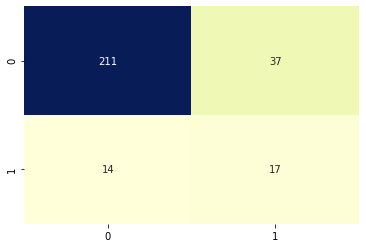

Precision: 0.3148148148148148
Recall: 0.5483870967741935
Precision + Recall: 0.8632019115890084
f1 score: 0.39999999999999997


In [9]:
from sklearn import metrics
loadedModel = keras.models.load_model("./bonus_model-16-0.999-0.31-0.55-f1-0.39.h5")
predict_ans = loadedModel.predict([image_validate_data, hw2_validate_data])
predict_ans = predict_ans.round() # Force output to [0, 1]
plot_precision_recall(label_validate_data, predict_ans)

print(f"f1 score: {metrics.f1_score(label_validate_data, predict_ans)}")
